In [1]:
import os
import trompy as tp

%run "..//src//vgp_helper_fx"

In [2]:
ROOT_FOLDER = "D:\\TestData\\2photon"

DATA_FOLDER = os.path.join(ROOT_FOLDER, "VGP_procd_data_22-12-05")
BEHAV_FOLDER = os.path.join(ROOT_FOLDER, "bonsai")
METAFILE = os.path.join(ROOT_FOLDER, "Metafile_VGP2.2.xls")
rows, header = tp.metafilereader(METAFILE, sheetname="2panalysispilot")


File is excel file. Making csv metafile first


In [3]:
# Goes through metafile assembling data from s2p files where possible

cell_data={}

for row in rows:
    try:
        key=row[0]+'_'+row[1]
        animal=row[0]
        day=row[1]
        date=int(row[3])
        
        s2p_folder = os.path.join(DATA_FOLDER, "sub-{}\\ses-{}".format(animal, day))
        events_file = os.path.join(BEHAV_FOLDER, "sub-{0}\\ses-{1}-{2}\\sub-{0}_ses-{1}_events.csv".format(animal, day, date))
        
        cell_data[key] = assemble_data(s2p_folder,events_file)
        cell_data[key]['animal'] = row[0]
        cell_data[key]['diet'] = row[4]
        cell_data[key]['solution'] = row[2]
        
    except FileNotFoundError:
        print('Cannot find file for', key)
        

In [4]:
cell_data["VGP302_029"]["df_responsive"]

,responsive,activated,inhibited
pump,4,6,0
lick,10,7,5
both,10,8,0
neither,50,53,69


In [5]:
cols = ["animal", "diet", "solution", "lick_activated"]
df_activated = pd.DataFrame(columns=cols)

for key, d in cell_data.items():
    percent_act = d["df_responsive"].loc["lick", "activated"] / np.sum(d["df_responsive"].loc[:,"activated"]) * 100
    data = np.array([d["animal"], d["diet"], d["solution"], percent_act])
    df_temp = pd.DataFrame({col: value for col, value in zip(cols, data)},
                          index=[key.split("_")[0]])

    df_activated = pd.concat([df_activated, df_temp])

In [59]:
df_pref = (df_activated.pivot_table(index=["animal", "diet"],
                         columns=["solution"],
                         values="lick_activated",
                         aggfunc="sum")
             .astype({"cas": "float", "malt": "float"})
#              .assign(pref=lambda df_: df_.cas / (df_.cas + df_.malt))
             .assign(pref=lambda df_: df_.cas - df_.malt)
            )


In [60]:
PRs = ["PR", "NRPR"]
NRs = ["NR", "PRNR"]

(df_pref
 .droplevel(0)
 .pref
 .reset_index()
 .query("diet in @NRs")
 .mean()
#  .loc["PR"]
)

C:\Users\jmc010\AppData\Local\Temp\ipykernel_20816\2691001650.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df_pref


pref    2.155869
dtype: float64

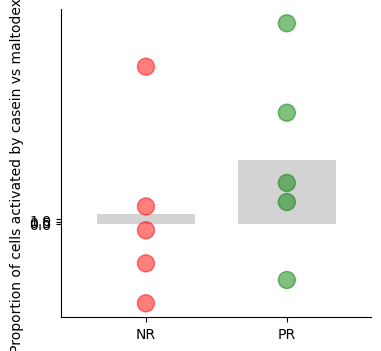

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

df = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
 .fillna(0)
 .assign(NR=lambda df_: df_.NR + df_.PRNR,
         PR=lambda df_: df_.PR + df_.NRPR)
 .drop(columns=["NRPR", "PRNR"])
)

f, ax = plt.subplots(figsize=(4,4))
x = [1,2]
for row in df.iterrows():
    y = [row[1].NR, row[1].PR]
#     ax.plot(x, y, color="grey")
    ax.scatter(x, y, s=150, color=["red", "green"], zorder=20, alpha=0.5)
    
ax.bar(x, [df.NR.mean(), df.PR.mean()], width=0.7, zorder=-1, color="lightgrey")
    
ax.set_ylabel("Proportion of cells activated by casein vs maltodextrin")
ax.set_yticks([0, 0.5, 1.0])

ax.set_xticks([1,2], labels=["NR", "PR"])
ax.set_xlim([0.4,2.6])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [70]:
df.PR

animal
VGP118     8.888889
VGP202    24.137931
VGP203   -12.155172
VGP302    43.540541
VGP310     4.760522
Name: PR, dtype: float64

C:\Users\jmc010\Miniconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


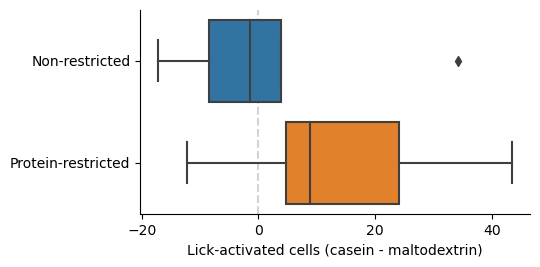

In [91]:
f, ax = plt.subplots(figsize=(6,3),
                     gridspec_kw={"left": 0.25, "bottom": 0.2})

sns.boxplot(data=df, orient="h", ax=ax)

ax.set_ylabel("")
ax.set_yticklabels(["Non-restricted", "Protein-restricted"])
ax.set_xticks([-20, 0, 20, 40])
ax.set_xlabel("Lick-activated cells (casein - maltodextrin)")

ax.axvline(0, color="lightgrey", linestyle="--", zorder=-1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig("..//output//grouped_casmalt_diff.png")

In [71]:
sns.boxplot?